## Regional IR-Drop Solver

Test the `RegionalIRDropSolver` which computes IR-drops at a subset of load nodes within a partitioned region using effective resistance and boundary conditions.

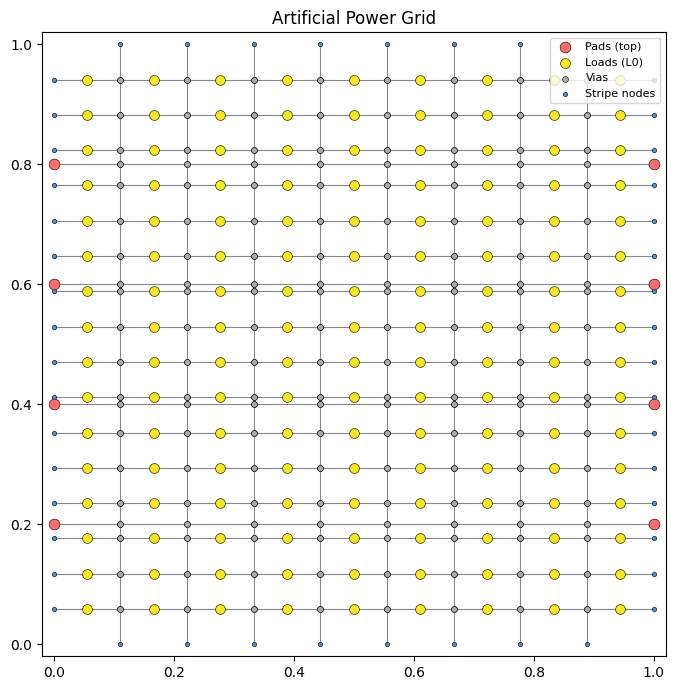

Regional solver test grid: 520 nodes, 652 edges
Loads: 144, Pads: 8


In [1]:
import numpy as np
from generate_power_grid import generate_power_grid


# Create a fresh grid for regional solver testing
G_regional, loads_regional, pads_regional = generate_power_grid(
    K=3,
    N0=16,
    I_N=1000,
    N_vsrc=8,
    max_stripe_res=5.0,   # Ω per stripe in layer 0
    max_via_res=0.1,      # Ω for vias between L0-L1; halves on higher vias
    load_current=0.01,
    seed=7,
    plot=True,
)

print(f"Regional solver test grid: {G_regional.number_of_nodes()} nodes, {G_regional.number_of_edges()} edges")
print(f"Loads: {len(loads_regional)}, Pads: {len(pads_regional)}")

In [2]:
from irdrop import PowerGridModel, StimulusGenerator, IRDropSolver, RegionalIRDropSolver, GridPartitioner, EffectiveResistanceCalculator

# Build model and calculator
model_regional = PowerGridModel(G_regional, pad_nodes=pads_regional, vdd=1.0)
calc_regional = EffectiveResistanceCalculator(model_regional)

c:\Users\Z0051DMJ\Workspace\SigmaDvd\sigma_dvd_prototype\venv\lib\site-packages\scipy\sparse\linalg\_dsolve\linsolve.py:597: SparseEfficiencyWarning: splu converted its input to CSC format
  return splu(A).solve


In [3]:
# Partition the grid into 3 regions
partitioner_regional = GridPartitioner(G_regional, loads_regional, pads_regional, seed=42)
part_result_regional = partitioner_regional.partition(P=3, axis='y')

print(f"Created {part_result_regional.num_partitions} partitions")
print(f"Load balance ratio: {part_result_regional.load_balance_ratio:.2f}")

# Select first partition for testing
partition = part_result_regional.partitions[0]
print(f"\nPartition {partition.partition_id}:")
print(f"  Interior nodes: {len(partition.interior_nodes)}")
print(f"  Separator nodes: {len(partition.separator_nodes)}")
print(f"  Load nodes: {len(partition.load_nodes)}")

Created 3 partitions
Load balance ratio: 1.20

Partition 0:
  Interior nodes: 159
  Separator nodes: 8
  Load nodes: 45


In [4]:
# Stimulus generator using discovered load nodes
stim_gen = StimulusGenerator(load_nodes=list(loads_regional.keys()), vdd=1.0, seed=7, graph=G_regional)
# Use seed parameter for reproducible load node selection and current distribution
meta = stim_gen.generate(1., percent=0.1, distribution="gaussian", gaussian_loc=1.0, gaussian_scale=0.2, seed=100)

In [5]:
meta.currents

{NodeID(layer=0, idx=197): np.float64(0.04615755812244201),
 NodeID(layer=0, idx=277): np.float64(0.07587301137865586),
 NodeID(layer=0, idx=276): np.float64(0.08738111214184316),
 NodeID(layer=0, idx=204): np.float64(0.06742158381728461),
 NodeID(layer=0, idx=260): np.float64(0.08494253555670206),
 NodeID(layer=0, idx=249): np.float64(0.07830908033296188),
 NodeID(layer=0, idx=270): np.float64(0.07414754290863362),
 NodeID(layer=0, idx=289): np.float64(0.05581049671466533),
 NodeID(layer=0, idx=188): np.float64(0.06831541660955519),
 NodeID(layer=0, idx=296): np.float64(0.07462785610905771),
 NodeID(layer=0, idx=191): np.float64(0.06450192491317222),
 NodeID(layer=0, idx=180): np.float64(0.07718639148289035),
 NodeID(layer=0, idx=227): np.float64(0.06271869505630992),
 NodeID(layer=0, idx=172): np.float64(0.0826067948558259)}

In [15]:
# Create regional solver
regional_solver = RegionalIRDropSolver(calc_regional)

# Define subset S (first 5 load nodes in the partition)
partition_loads = sorted(list(partition.load_nodes), key=lambda n: (n.layer, n.idx))
# randomly sample 5 nodes in the partition with fixed seed for reproducibility
rng = np.random.RandomState(4)
S = set(rng.choice(partition_loads, size=5, replace=False))

# Define region R and boundary A
R = partition.all_nodes
A = partition.separator_nodes

active_loads = meta.currents
# Define near loads (all loads in region R) and far loads (outside R)
loads_in_R = set(partition.load_nodes)
I_R = {node: active_loads[node] for node in loads_in_R if node in active_loads}
all_far_loads = set(active_loads.keys()) - loads_in_R
I_F = {node: active_loads[node] for node in all_far_loads}

print(f"Subset S: {len(S)} nodes")
print(f"Near loads (in R): {len(I_R)} nodes")
print(f"Far loads (outside R): {len(I_F)} nodes")
print(f"Boundary nodes (A): {len(A)} nodes")

Subset S: 5 nodes
Near loads (in R): 6 nodes
Far loads (outside R): 8 nodes
Boundary nodes (A): 8 nodes


In [16]:
# Compute IR-drops using regional solver
ir_drops_regional, drop_near, drop_far = regional_solver.compute_ir_drops(S, R, A, I_R, I_F)

print(f"Computed IR-drops for {len(ir_drops_regional)} nodes\n")
print("IR-drop results:")
for node in S:
    drop = ir_drops_regional[node]
    drop_n = drop_near[node]
    drop_f = drop_far[node]
    voltage = 1.0 - drop
    print(f"  {node}: IR-drop = {drop:.6f} V (near={drop_n:.6f}, far={drop_f:.6f}), Voltage = {voltage:.6f} V")

Computed IR-drops for 5 nodes

IR-drop results:
  NodeID(layer=0, idx=198): IR-drop = 0.033263 V (near=0.023999, far=0.009265), Voltage = 0.966737 V
  NodeID(layer=0, idx=164): IR-drop = 0.036680 V (near=0.028391, far=0.008289), Voltage = 0.963320 V
  NodeID(layer=0, idx=192): IR-drop = 0.032299 V (near=0.022823, far=0.009476), Voltage = 0.967701 V
  NodeID(layer=0, idx=175): IR-drop = 0.026700 V (near=0.019212, far=0.007488), Voltage = 0.973300 V
  NodeID(layer=0, idx=204): IR-drop = 0.049349 V (near=0.041910, far=0.007439), Voltage = 0.950651 V


### Validation: Compare Regional Solver vs Full Solver

Verify the regional solver accuracy by comparing against the full IR-drop solver.

In [17]:
# Run full solver for comparison
full_solver_regional = IRDropSolver(model_regional)
result_full_regional = full_solver_regional.solve(active_loads)

# Extract IR-drops for nodes in S
ir_drops_full = {node: result_full_regional.ir_drop[node] for node in S}

# Compare results
print("Comparison: Regional vs Full Solver\n")
print(f"{'Node':<20} {'Regional':<12} {'Full':<12} {'Error':<12} {'Near':<12} {'Far':<12}")
print("-" * 80)

errors = []
for node in S:
    drop_regional = ir_drops_regional[node]
    drop_full = ir_drops_full[node]
    error = abs(drop_regional - drop_full)
    errors.append(error)
    print(f"{str(node):<20} {drop_regional:<12.6f} {drop_full:<12.6f} {error:<12.2e} {drop_near[node]:<12.6f} {drop_far[node]:<12.6f}")

print(f"\nError Statistics:")
print(f"  Mean absolute error: {np.mean(errors):.2e} V")
print(f"  Max absolute error:  {np.max(errors):.2e} V")
print(f"  RMS error:           {np.sqrt(np.mean(np.array(errors)**2)):.2e} V")

Comparison: Regional vs Full Solver

Node                 Regional     Full         Error        Near         Far         
--------------------------------------------------------------------------------
NodeID(layer=0, idx=198) 0.033263     0.033263     1.97e-14     0.023999     0.009265    
NodeID(layer=0, idx=164) 0.036680     0.036680     2.42e-14     0.028391     0.008289    
NodeID(layer=0, idx=192) 0.032299     0.032299     2.29e-14     0.022823     0.009476    
NodeID(layer=0, idx=175) 0.026700     0.026700     2.17e-14     0.019212     0.007488    
NodeID(layer=0, idx=204) 0.049349     0.049349     1.69e-14     0.041910     0.007439    

Error Statistics:
  Mean absolute error: 2.11e-14 V
  Max absolute error:  2.42e-14 V
  RMS error:           2.12e-14 V


### Visualize Regional Solver Results

Visualize the partitioned grid with the computed IR-drops at subset S.

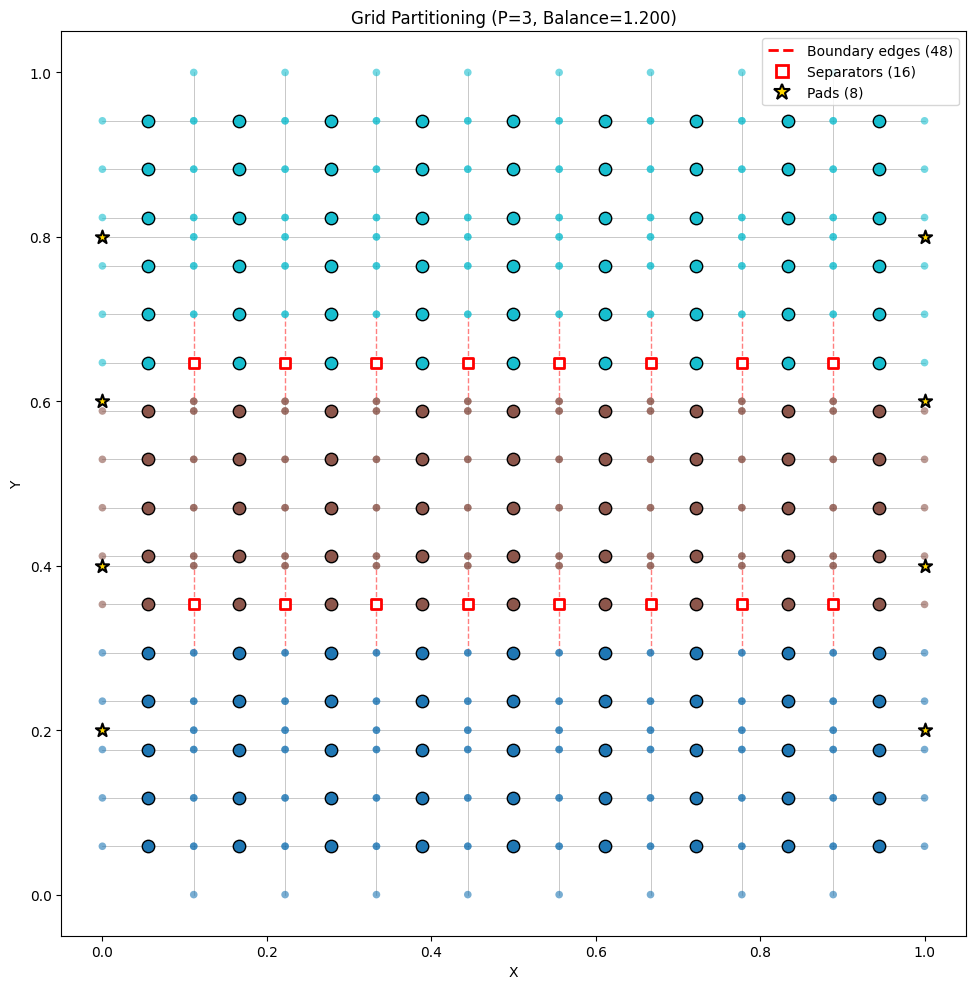

In [18]:
# Visualize the partitioned grid
fig_part, ax_part = partitioner_regional.visualize_partitions(part_result_regional, figsize=(12, 10), show=False)
display(fig_part)

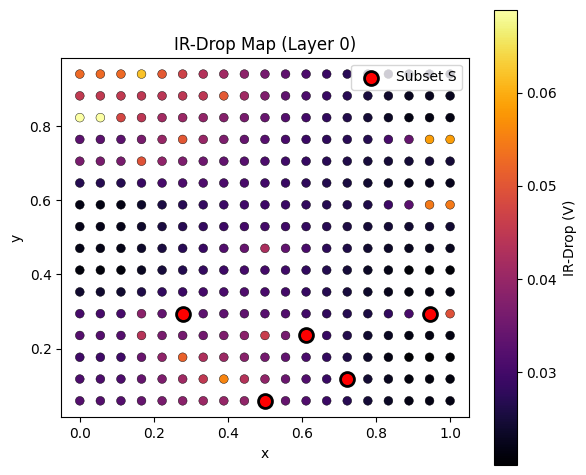

In [19]:
from IPython.display import display
from irdrop import plot_ir_drop_map

# Create a voltage map with regional solver results
# Build full voltage dictionary from regional results
voltages_regional_map = {}
for node in S:
    voltages_regional_map[node] = 1.0 - ir_drops_regional[node]

# Plot IR-drop map for layer 0 showing the subset S nodes
fig_irdrop, ax_irdrop = plot_ir_drop_map(G_regional, result_full_regional.voltages, vdd=1.0, layer=0)

# Highlight the subset S nodes
for node in S:
    if node.layer == 0:
        x, y = G_regional.nodes[node]['xy']
        ax_irdrop.scatter([x], [y], c='red', s=100, marker='o', edgecolors='black', linewidths=2, zorder=10, label='Subset S')

# Remove duplicate labels
handles, labels = ax_irdrop.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax_irdrop.legend(by_label.values(), by_label.keys())

display(fig_irdrop)

### Visualize Current Map with Load Currents

Show the resistor currents with load current magnitudes overlaid as colored dots.

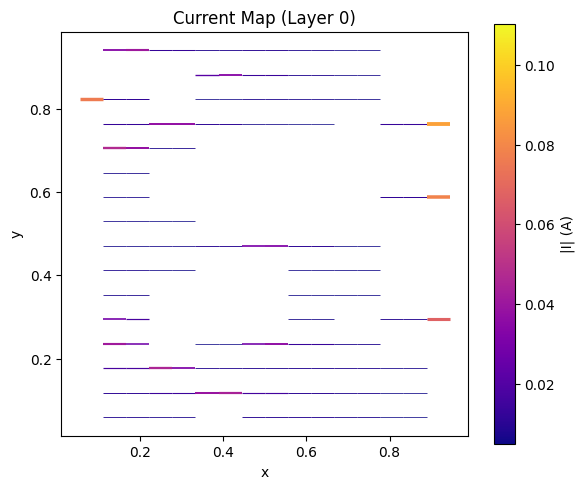

In [20]:
from irdrop import plot_current_map
fig, ax = plot_current_map(G_regional, result_full_regional.voltages, layer=0, min_current=5.e-3, show=True)
display(fig)

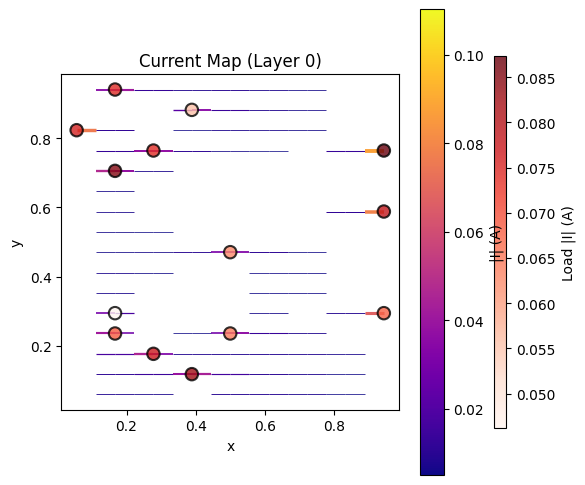

In [12]:
# Plot current map with load currents for the regional solver test
fig_currents, ax_currents = plot_current_map(
    G_regional, 
    result_full_regional.voltages, 
    layer=0, 
    min_current=5e-3, 
    loads_current=active_loads,
    show=False
)
display(fig_currents)